In [1]:
from sklearn.mixture import GaussianMixture
import cv2
import imageio
import numpy as np
import pdb
import math
from matplotlib import pyplot as plt
import random

import sys
sys.path.append("../");
import superpixels as sp
from helpers import get_smaller_image
from models import *

filename = '../data/toothpick.mp4'
vid = imageio.get_reader(filename, 'ffmpeg')

In [2]:
def display_superpixels(image, mask, sp_ids):
    out = np.zeros(image.shape).astype(np.uint8) # astype is needed otherwise show weird colors.
    idx = np.zeros(mask.shape)
    for i in sp_ids:
        idx = (mask==i)
        out[idx] = image[idx]
    plt.imshow(out)

def calculate_score(clf_o, clf_b, superpixel):
#     score_o = math.exp(clf_o.score(np.array(superpixel)))
#     score_b = math.exp(clf_b.score(np.array(superpixel)))
    score_o = clf_o.score(np.array(superpixel))
    score_b = clf_b.score(np.array(superpixel))
    if (score_o + score_b) == 0:
        return 0
    else:
        return (score_o / (score_o + score_b))
#     return (score_o / (score_o + score_b))

def split_superpixels(image, maps, obj_ids):
    max_sp_id = np.max(maps)
    sp_o = []
    sp_b = []
    for i in range(max_sp_id+1):
        superpixel = image[maps == i]
        if i in obj_ids:
            sp_o.append(process_superpixel(superpixel))
        else:
            sp_b.append(process_superpixel(superpixel))
    sp_b = np.array(sp_b)
    random.sample(range(len(sp_b)), int(len(sp_b)/2))
    return (sp_o, sp_b)

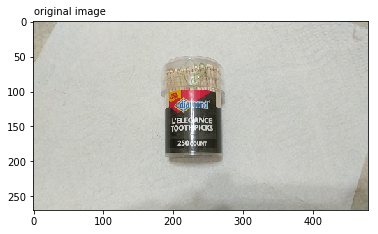

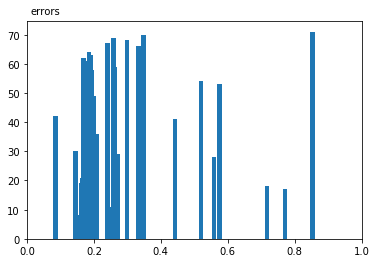

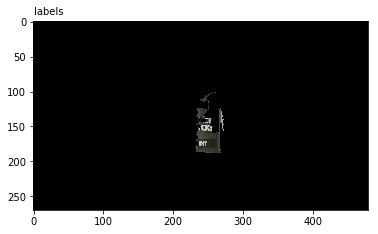

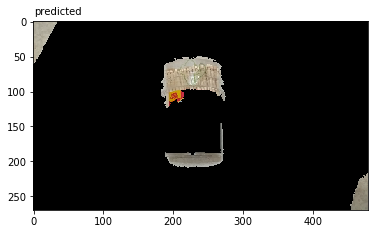

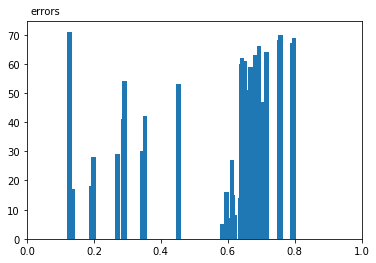

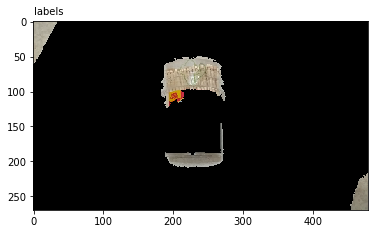

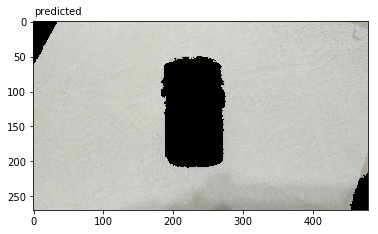

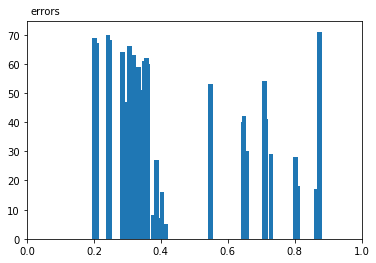

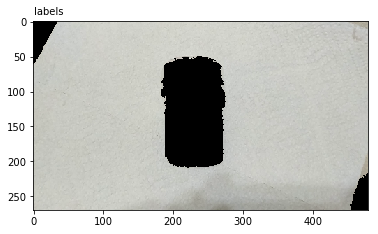

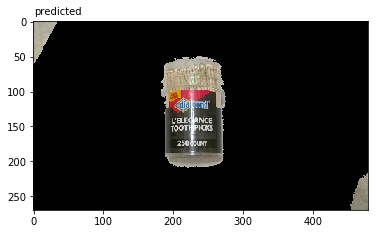

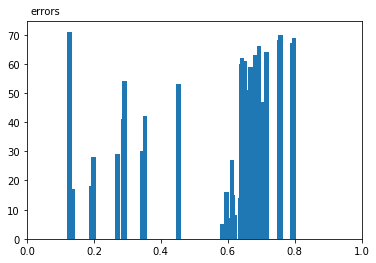

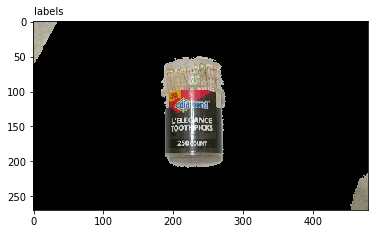

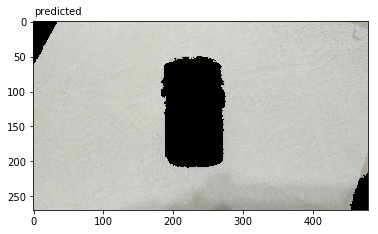

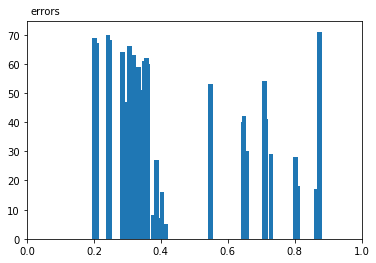

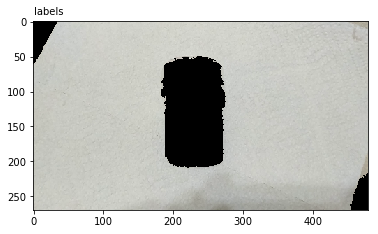

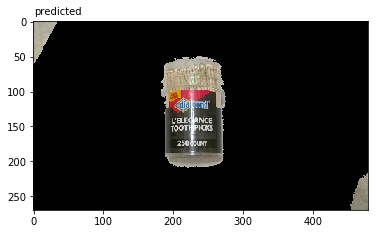

In [14]:
# We will work only on one image iteratively
maps = None
image = None

# Initial superpixel id that contains object.
init_obj_id = None 

threshold = 0.5
# threshold = 1.0

for i in range(1):
    image = get_smaller_image(vid, i)
    sp.num_superpixels = 100
    maps = sp.extract_superpixels(image)

    # fixation point is assumed to be at the center of the image.
    init_obj_id = maps[int(image.shape[0]/2.0), int(image.shape[1]/2.0)]

plt.figure()
plt.imshow(image)
plt.text(0, -10, "original image")
# Learn object and background color models
clf_o = GaussianMixture(n_components=2, random_state=42)
clf_b = GaussianMixture(n_components=2, random_state=42)

def train_iterate(clf_o, clf_b, obj_ids, image, maps):
    """ Training iteratively.
    
    `clf_o`, `clf_b` can be used for the next
    training iteration.
    
    Returns: result_obj_ids to be used in the next
             training iteration.
    """
    global threshold
    result_obj_ids = []
    scores = []
    max_sp_id = np.max(maps)
    objects, backgrounds = split_superpixels(image, maps, obj_ids)
#     print(objects[0].shape)
    for o in objects:
        clf_o.fit(o)
    for b in backgrounds:
        clf_b.fit(b)
#     print(clf_o.means_)
#     print(clf_b.means_)
    # Get object ids that we can use for next training iteration
    for i in range(max_sp_id+1):
#         print(superpixel)
        superpixel = image[maps == i]
        score = calculate_score(clf_o, clf_b, superpixel)
        scores.append(score)
        if score >= threshold:
            result_obj_ids.append(i)
#     print(scores)
    plt.figure()
    plt.bar(scores, np.arange(max_sp_id+1), 1/len(scores))
    plt.xlim(0,1.0)
    plt.text(0.01,77,"errors")
#     print(result_obj_ids)
    plt.figure()
    display_superpixels(image, maps, obj_ids)
    plt.text(0,-10,"labels")
    plt.figure()
    display_superpixels(image, maps, result_obj_ids)
    plt.text(0,-10,"predicted")
    
    return result_obj_ids

obj_ids = [init_obj_id]
for i in range(5):
    obj_ids = train_iterate(clf_o, clf_b, obj_ids, image, maps)

plt.show()

In [149]:
print(clf_b.weights_)
print(clf_b.means_)
print(clf_b.covariances_)

[ 0.50937768  0.49062232]
[[ 161.52888319  160.23660644  152.35156275]
 [ 176.11446898  176.34856968  170.50777946]]
[[[ 28.19647554  29.16665002  29.65121891]
  [ 29.16665002  31.63232074  32.09497163]
  [ 29.65121891  32.09497163  33.7896152 ]]

 [[ 16.91664427  18.18185728  17.60731595]
  [ 18.18185728  20.53711693  19.16876579]
  [ 17.60731595  19.16876579  20.88807671]]]


In [61]:
print(clf_o.weights_)
print(clf_o.means_)
print(clf_o.covariances_)

[ 1.]
[[ 143.32792208  137.42316017  120.57251082]]
[[[ 106.54290101  101.53547886  102.77762903]
  [ 101.53547886  101.099075    103.13544185]
  [ 102.77762903  103.13544185  108.40708084]]]
